In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import nxviz as nv 

def drawRNA(s,bps):
    nodes = [(i, {"nt":s[i],"label":"s"}) for i in range(len(s))]
    ax = plt.figure(figsize=(20,6))
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(bps)
    nv.arc(G, node_color_by="nt")

C:\anaconda3\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


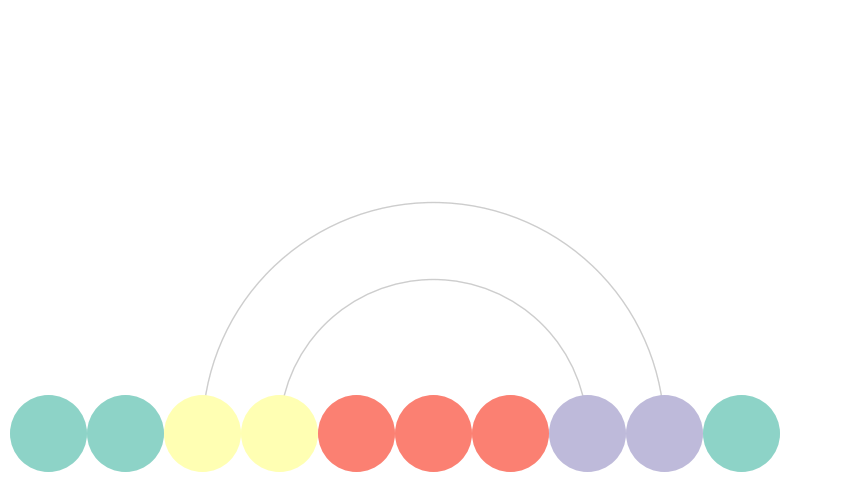

In [3]:
drawRNA("AACCUUUGGA",[(2,8),(3,7)])

'..((...)).'

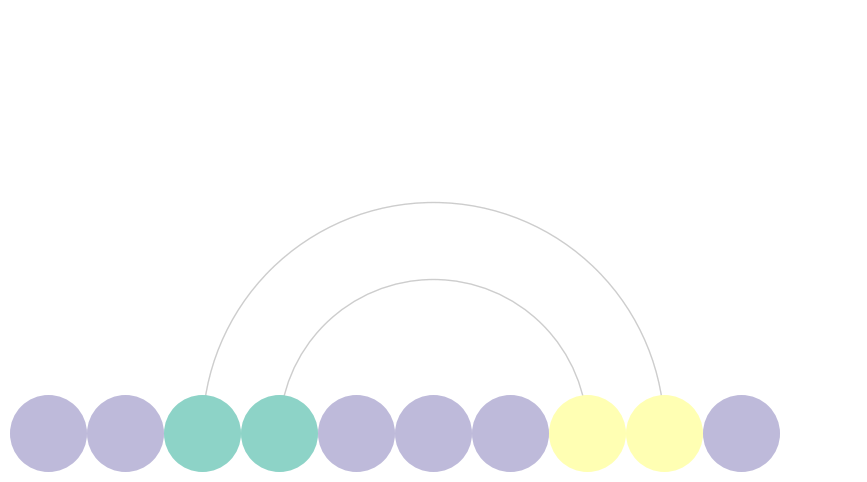

In [4]:
def displaySS(bps, n):
    l = ["." for i in range(n)]
    for (i,j) in bps:
        (l[i],l[j]) = ("(",")")
    return "".join(l)

ss = displaySS([(2,8),(3,7)],10)
drawRNA(ss,[(2,8),(3,7)])
ss

In [5]:
def parseSS(ss):
    p = []
    bps = []
    for i,c in enumerate(ss):
        if c=="(":
            p.append(i)
        elif c==")":
            j = p.pop()
            bps.append((j,i))
    return (bps,len(ss))
parseSS("((.(...)))")

([(3, 7), (1, 8), (0, 9)], 10)

In [6]:
seq = "((..)(...))(..)"
bps,n = parseSS(seq)
displaySS(bps,n)

'((..)(...))(..)'

In [7]:
BP_ENERGIES = {
    "AU":-2,
    "UA":-2,
    "CG":-3,
    "GC":-3,
    "GU":-1,
    "UG":-1,
}

def canBP(c1,c2):
    return c1+c2 in BP_ENERGIES

def countSS(s, debug=False,theta=1):
    n = len(s)
    C = [[1 for j in range(n)] for i in range(n)]
    for m in range(theta+2,n+1):
        for i in range(0,n-m+1):
            j = i+m-1
            C[i][j] = C[i+1][j]
            for k in range(i+theta+1,j+1):
                if canBP(s[i],s[k]) or debug:
                    A = C[i+1][k-1]
                    B = 1
                    if k<j:
                        B = C[k+1][j]
                    C[i][j] += A*B
    return C

import random
def stochastic_backtrack(i,j,s,C,debug=False,theta=1):
    if j-i+1 < theta+2:
        return []
    r = random.random()*C[i][j]
    r -= C[i+1][j]
    if r<0:
        return stochastic_backtrack(i+1,j,s,C,debug,theta)
    for k in range(i+theta+1,j+1):
        if canBP(s[i],s[k]) or debug:
            A = C[i+1][k-1]
            B = 1
            if k<j:
                B = C[k+1][j]
            r -= A*B
            if r<0:
                lA = stochastic_backtrack(i+1,k-1,s,C,debug,theta)
                lB = stochastic_backtrack(k+1,j,s,C,debug,theta)
                return [(i,k)] + lA + lB
    print("AAAaarararrrggghgh!!")
    

In [8]:
SAMPLES = 228300
for s,d in [#("A",False),
            #("CAG",False),
            #("CAGU",False),
            #("AAAA",True),
            #("AAAAAAAA",True),
            ("AAAAAAAAAAAA",True),
            #("AAAAAAAAAAAA"*10,True)
           ]:
    print(s)
    C = countSS(s,d)
    stats = {}
    for i in range(SAMPLES):
        bps = stochastic_backtrack(0,len(s)-1,s,C,d)
        ss = displaySS(bps,len(s))
        if ss not in stats:
            stats[ss] = 0
        stats[ss] += 1
    for nb,ss in sorted([(stats[s],s) for s in stats]):
        print(nb,ss)

AAAAAAAAAAAA
67 ((((.))..)).
68 ..((......))
69 .(((.)...).)
72 (.(..(..).))
74 (...(..)..).
74 .(.(.(.))..)
74 ..(.(.))(..)
74 ..(.).......
76 (..(.)(.)..)
76 (..).(...)..
76 ....(.).....
77 ((.(.(..))))
77 ....(.(.)..)
78 ((.))....(.)
78 (.)....(.)..
78 .(.(.).(..))
78 .(.)(.).....
78 ..(...(.))..
79 (((.).))....
79 ((..(.))..).
79 (.(.).....).
79 (..(...).)..
79 .(.).((.)..)
79 ..(.(.(..)))
80 (((...))..).
80 ((..(.).).).
80 (.(.)).(.)..
80 (.)(.(.(.)))
80 (.).(..)(.).
80 (.)..(.....)
80 (.)......(.)
80 (..(.(..)).)
80 (..)(.(..)).
80 .((.)).((.))
80 .((.)).(...)
80 .(..)((.)..)
80 ..(((..))..)
80 ...(.)(.)...
81 (((.).(.)).)
81 ((..))(...).
81 (.((.(.)).))
81 (.(.)..)(.).
81 (.).(...)(.)
81 (...)..(..).
81 .(((.)).)...
81 .((....))...
81 .(.(..).(.))
81 .(..(.(.).))
81 ..(.(.))....
81 ..(.(..(.)))
81 ..(....(..))
81 ....(...)(.)
81 ....(......)
82 ((((.))(.)))
82 ((.))((..)).
82 ((.).)...(.)
82 (.((.(.))).)
82 (.(.)((.).))
82 (.)(.(..))..
82 (..(.)....).
82 (..)(((.))).
82 (..)((.)

In [9]:
import math 

RT = 0.001986*(273+2237)

def BF(E):
    return math.exp(-E/RT)

def partition_function(s, theta=1):
    n = len(s)
    C = [[1 for j in range(n)] for i in range(n)]
    for m in range(theta+2,n+1):
        for i in range(0,n-m+1):
            j = i+m-1
            C[i][j] = C[i+1][j]
            for k in range(i+theta+1,j+1):
                if canBP(s[i],s[k]):
                    A = BF(BP_ENERGIES[s[i]+s[k]]) * C[i+1][k-1]
                    B = 1
                    if k<j:
                        B = C[k+1][j]
                    C[i][j] += A*B
    return C


In [10]:
seq = "GGGGAAACCCC"
C = partition_function(seq)
C[0][len(seq)-1]

258.5965029004957

In [11]:
def stochastic_backtrack_PF(i,j,s,C,theta=1):
    if j-i+1 < theta+2:
        return []
    r = random.random()*C[i][j]
    r -= C[i+1][j]
    if r<0:
        return stochastic_backtrack_PF(i+1,j,s,C,theta)
    for k in range(i+theta+1,j+1):
        if canBP(s[i],s[k]):
            A = BF(BP_ENERGIES[s[i]+s[k]]) * C[i+1][k-1]
            B = 1
            if k<j:
                B = C[k+1][j]
            r -= A*B
            if r<0:
                lA = stochastic_backtrack_PF(i+1,k-1,s,C,theta)
                lB = stochastic_backtrack_PF(k+1,j,s,C,theta)
                return [(i,k)] + lA + lB
    print("AAAaarararrrggghgh!!")

In [12]:
seq = "GAUCAGCUACGAUCGACUAGCUACGAUCGACUA"
SAMPLES = 50000
C = partition_function(seq)
stats = {}
for i in range(SAMPLES):
    bps = stochastic_backtrack_PF(0,len(seq)-1,seq,C)
    for (i,j) in bps:        
        if (i,j) not in stats:
            stats[(i,j)] = 0
        stats[(i,j)] += 1
for nb,ss in sorted([(stats[s],s) for s in stats]):
    print(ss,nb/SAMPLES)


(2, 14) 0.00706
(0, 17) 0.00718
(5, 17) 0.00756
(12, 28) 0.00756
(19, 31) 0.00798
(14, 31) 0.00824
(0, 12) 0.00836
(0, 21) 0.00866
(2, 24) 0.00886
(10, 26) 0.00888
(7, 24) 0.00906
(14, 26) 0.00914
(10, 21) 0.00922
(5, 21) 0.0094
(17, 28) 0.00952
(15, 31) 0.01028
(10, 31) 0.01062
(2, 19) 0.0107
(12, 24) 0.01102
(7, 19) 0.01112
(2, 10) 0.01116
(17, 29) 0.01126
(5, 26) 0.01164
(0, 26) 0.01214
(16, 28) 0.0124
(7, 28) 0.01254
(14, 30) 0.01268
(2, 28) 0.01316
(5, 31) 0.01354
(0, 7) 0.01406
(2, 18) 0.01524
(24, 31) 0.01546
(10, 17) 0.01548
(7, 14) 0.01582
(5, 12) 0.01584
(17, 24) 0.01586
(14, 21) 0.01616
(21, 28) 0.01628
(1, 17) 0.01632
(3, 19) 0.01666
(19, 26) 0.01666
(11, 31) 0.01678
(12, 19) 0.0169
(12, 32) 0.01702
(4, 12) 0.01748
(4, 26) 0.01868
(0, 16) 0.02058
(1, 21) 0.02182
(2, 22) 0.02184
(2, 15) 0.02274
(4, 17) 0.0228
(3, 14) 0.02364
(18, 26) 0.024
(17, 25) 0.02454
(7, 25) 0.02476
(20, 28) 0.02514
(7, 29) 0.02542
(10, 30) 0.02552
(8, 26) 0.0256
(5, 13) 0.02568
(12, 29) 0.02602
(19, 2

In [16]:
def mfe(s, theta=1):
    n = len(s)
    C = [[0 for j in range(n)] for i in range(n)]
    for m in range(theta+2,n+1):
        for i in range(0,n-m+1):
            j = i+m-1
            C[i][j] = C[i+1][j]
            for k in range(i+theta+1,j+1):
                if canBP(s[i],s[k]):
                    A = BP_ENERGIES[s[i]+s[k]] + C[i+1][k-1]
                    B = 0
                    if k<j:
                        B = C[k+1][j]
                    C[i][j] = min(C[i][j], A + B)
    return C

def backtrack_mfe(i,j,s,C,theta=1):
    if j-i+1 < theta+2:
        return []
    if C[i][j] == C[i+1][j]:
        return backtrack_mfe(i+1,j,s,C,theta)
    for k in range(i+theta+1,j+1):
        if canBP(s[i],s[k]):
            A = BP_ENERGIES[s[i]+s[k]] + C[i+1][k-1]
            B = 0
            if k<j:
                B = C[k+1][j]
            if C[i][j] == A+B:
                lA = backtrack_mfe(i+1,k-1,s,C,theta)
                lB = backtrack_mfe(k+1,j,s,C,theta)
                return [(i,k)] + lA + lB
    print("AAAaarararrrggghgh!!")

GAUCAGCUACGAUCGACUAGCUACGAUCGACUA
..(.((.(.((((((.)(.(.)).))))))))) -12


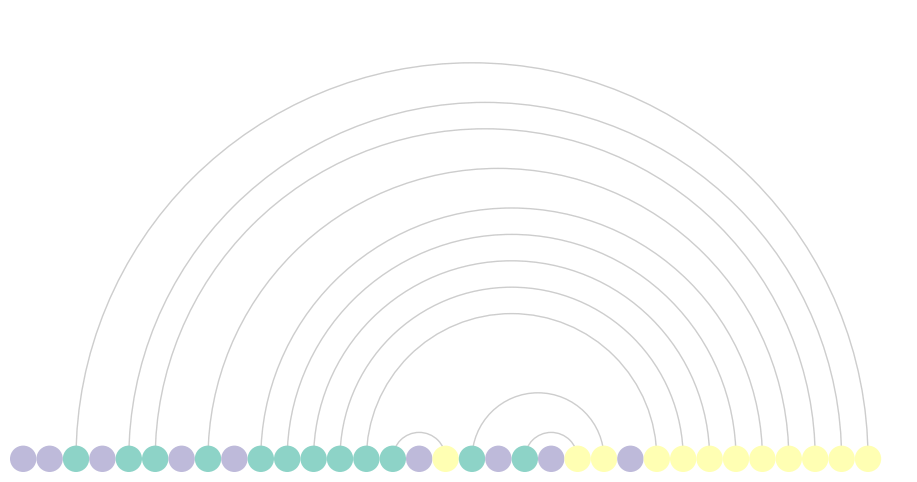

In [22]:
BP_ENERGIES = {
    "AU":-1,
    "UA":-1,
    "CG":-1,
    "GC":-1,
    "GU":-1,
    "UG":-1,
}
seq = "GAUCAGCUACGAUCGACUAGCUACGAUCGACUA"
theta=1
C = mfe(seq,theta)
bps = backtrack_mfe(0,len(seq)-1,seq,C,theta=theta)
ss = displaySS(bps,len(seq))
print(seq)
print(ss,C[0][len(seq)-1])
drawRNA(ss,bps)

GAUCAGCUACGAUCGACUAGCUACGAUCGACUA
(..)((.(.((((((((..).).))))))))). -31


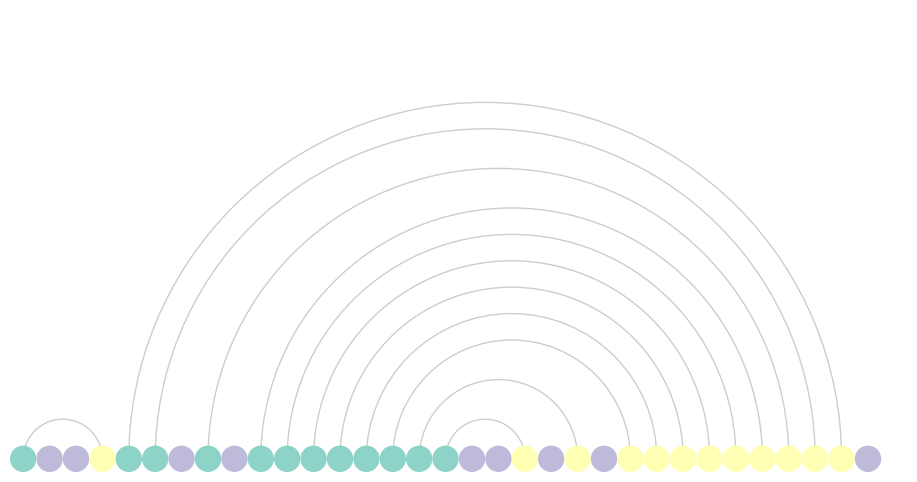

In [23]:
BP_ENERGIES = {
    "AU":-2,
    "UA":-2,
    "CG":-3,
    "GC":-3,
    "GU":-1,
    "UG":-1,
}
C = mfe(seq,theta)
bps = backtrack_mfe(0,len(seq)-1,seq,C,theta=theta)
ss = displaySS(bps,len(seq))
print(seq)
print(ss,C[0][len(seq)-1])
drawRNA(ss,bps)

In [27]:
def backtrack_subopt(i,j,delta,s,C,theta=1):
    if j-i+1 < theta+2:
        return [([],0.)]
    subopts = []
    if C[i+1][j] - C[i][j] <= delta:
        delta_update = delta - (C[i+1][j] - C[i][j])
        subopts += backtrack_subopt(i+1,j,delta_update,s,C,theta)
    for k in range(i+theta+1,j+1):
        if canBP(s[i],s[k]):
            Ebp = BP_ENERGIES[s[i]+s[k]]
            A =  Ebp + C[i+1][k-1]
            B = 0
            if k<j:
                B = C[k+1][j]
            if A+B - C[i][j] <= delta:
                delta_update = delta - (A+B - C[i][j])
                lA = backtrack_subopt(i+1,k-1,delta_update,s,C,theta)
                lB = backtrack_subopt(k+1,j,delta_update,s,C,theta)
                for bpA,EA in lA:
                    for bpB,EB in lB:
                        Ec = EA+EB+Ebp
                        if Ec - C[i][j] <= delta:
                            subopts.append(([(i,k)] + bpA + bpB, Ec))
    return subopts

In [37]:
BP_ENERGIES = {
    "AU":-2,
    "UA":-2,
    "CG":-3,
    "GC":-3,
    "GU":-1,
    "UG":-1,
}
seq = "GAUCAGCUACGAUCGACUAGCUACGAUCGACUA"
theta = 3
C = mfe(seq,theta)
delta = 3
print(seq)
for bps,E in backtrack_subopt(0,len(seq)-1,delta,seq,C,theta=theta):
    ss = displaySS(bps,len(seq))
    print(ss,E)
    #drawRNA(ss,bps)

GAUCAGCUACGAUCGACUAGCUACGAUCGACUA
....((...)(.(((((..(...)).)))))). -24.0
....((.(.((((((..(....)))))))))). -25.0
....((.(.(((((((.....).))))))))). -25.0
....(((...).(((((..(...)).)))))). -24.0
...(.(...))((((((..(...)).)))).). -24.0
..((.(...)))(((((..(...)).))))... -24.0
..((.(...)))(((((..(...)).)))...) -24.0
..(..(...)(.(((((..(...)).))))).) -24.0
..(..(.(.((((((..(....))))))))).) -25.0
..(..(.(.(((((((.....).)))))))).) -25.0
..(..((...).(((((..(...)).))))).) -24.0
..(.(..(.((((((..(....)))))))).)) -24.0
..(.(..(.(((((((.....).))))))).)) -24.0
..(.((...)(..((((..(...)).))).))) -24.0
..(.((...)(.(((.(..(...))..)))))) -24.0
..(.((...)(.((((.(.(...)).))))))) -24.0
..(.((...)(.((((.(..(...))))))))) -25.0
..(.((...)(.((((.(.(...).)))))))) -25.0
..(.((...)(.(((((..(...)).))))))) -26.0
..(.((...)(.((((((....).).))))))) -25.0
..(.((...((((((..(....))))))).))) -25.0
..(.((...(((((((.....).)))))).))) -25.0
..(.((.(...)((((.(..(...))))))))) -24.0
..(.((.(...)((((.(.(...).)))))))) -24.0
..(.((